# Author

In [ ]:
__author__ = 'Phil Marshall <pjm@stanford.edu>'
__version__ = '20190529' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['des_dr1', 'des_dr1.des_gaia2']

# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/known-issues.php

<a class="anchor" id="import"></a>
# Imports and initialization

In [1]:
#std lib
from collections import OrderedDict
from getpass import getpass
import warnings
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

In [2]:
# print(qc.schema('gaia_dr2',format='',profile='default'))

<a class="anchor" id="clustering"></a>
# K-Means Photometric-Dynamical Clustering in the GAIA Data

Let's do the simplest possible clustering analysis to see whether we can identify dwarf satellite galaxies in the GAIA data. First we need a validation set of stars that are known to be either members of the known DES dwarf galaxies, or known not to be. Then, we can find clusters in the total set, and see whether we recover the known dwarfs.

This notebook builds on Ethan Nadler's [`EriII_Gaia_x_DES` notebook](EriII_Gaia_x_DES.ipynb).

## Building the Validation Set

### Get DES stars

In [3]:
# Dwarf names from Bechtol et al. (2015)
names = ['Eri II']#,'Tuc II','Hor I','Pic I','Phe II','Eri III']

radius = 1. # search radius in degrees

# columns to query for
columns = '''ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread_model_r,spread_model_z,class_star_g,class_star_i,class_star_r,class_star_z,
    kron_radius,tilename,coadd_object_id'''

In [4]:
# a function to retrieve data around a point in the sky
def getDESData(ra,dec,radius=1.0,columns='*'):

    query_template =\
    """SELECT {0} FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df

# gets coordinates of a named source
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec

In [5]:
dgs = OrderedDict([(name,dict()) for name in names]) # empty dictionary of dictionaries

# loop over dwarfs, resolving coordinates and querying for photometry data
for j,name in enumerate(dgs.keys()):
    print('{:s}: resolving coordinates and querying for data'.format(name))
    coords, ra0, dec0 = resolve_coordinates(name)
    dgs[name]['ra0'] = ra0
    dgs[name]['dec0'] = dec0
    df = getDESData(ra0,dec0,radius=radius,columns=columns)
    dgs[name]['df'] = df
print("Done.")

Eri II: resolving coordinates and querying for data
Done.


In [6]:
ramax, ramin = np.max(dgs['Eri II']['df']['ra'].values), np.min(dgs['Eri II']['df']['ra'].values)

In [7]:
decmin, decmax = np.min(dgs['Eri II']['df']['dec'].values), np.max(dgs['Eri II']['df']['dec'].values)

### Get DES x Gaia stars

In [8]:
# a function to retrieve data around a point in the sky
def getXGaiaData(ra,dec,columns='*'):

    query_template =\
    """SELECT {0} FROM des_dr1.des_gaia2
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df

In [9]:
def getGaiaData(ra,dec,radius=1.0,columns='*'):

    query_template =\
    """SELECT {0} FROM gaia_dr2.des_dr1
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df


In [10]:
# Standard notebook imports
from __future__ import print_function
import getpass
from dl import authClient, queryClient, storeClient

In [11]:
# Get the security token for the datalab user
token = authClient.login ('drphilmarshall',getpass.getpass('Account password: '))
if not authClient.isValidToken (token):
    print ('Error: invalid user login (%s)' % token)
else:
    print ("Login token:   %s" % token)

Account password: ········
Error: invalid user login (Error: Invalid password)


In [12]:
query = 'select * from gaia_dr2.des_dr1 where ra <= 58 and ra >= 54 and dec >= -45 and dec <= -42'
response = queryClient.query(token, adql = query, fmt = 'csv')

In [13]:
import csv 
reader = csv.reader(response.split('\n'), delimiter=',') 

results = []

i = 0
for row in reader: # each row is a list
    results.append(row)
    i+=1

In [14]:
result_array = np.asarray(results[1:-2])

In [15]:
ids = [int(numeric_string) for numeric_string in result_array[:,4]]
gaia_ids = [int(numeric_string) for numeric_string in result_array[:,0]]

In [16]:
gaia_matched_ids = []

k=0
for j in range(len(ids)):
    if (ids[j] in dgs['Eri II']['df']['coadd_object_id'].values):
        gaia_matched_ids.append(gaia_ids[j])
        k+=1

In [17]:
query = 'select source_id, b, l, ra, dec, parallax, parallax_error, parallax_pmdec_corr, parallax_pmra_corr, pmdec, pmdec_error, pmra, pmra_error, pmra_pmdec_corr, radial_velocity, radial_velocity_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag from gaia_dr2.gaia_source where ra <= 58 and ra >= 54 and dec >= -45 and dec <= -42'
response = queryClient.query(token, adql = query, fmt = 'csv')

In [18]:
reader = csv.reader(response.split('\n'), delimiter=',') 
results = []

i = 0
for row in reader: # each row is a list
    results.append(row)
    i+=1

In [19]:
result_array = np.asarray(results[1:-2])

In [20]:
gids = [int(numeric_string) for numeric_string in result_array[:,0]]

In [21]:
import pandas as pd
dgaia = pd.DataFrame()

In [22]:
keys = ["id", "b", "l", "ra", "dec", "parallax", "parallax_err",
                      "parallax_pmdec_corr", "parallax_pmra_corr", "pmdec", "pmdec_err",
                     "pmra", "pmra_err", "pmra_pmdec_corr", "vrad", "vrad_err",
                     "Gmag", "BPmag", "RPmag"]

In [23]:
dgaia = pd.DataFrame({"id": [], "b": [], "l": [], "ra": [], "dec": [], "parallax": [], "parallax_err": [],
                      "parallax_pmdec_corr": [], "parallax_pmra_corr": [], "pmdec": [], "pmdec_err": [],
                     "pmra": [], "pmra_err": [], "pmra_pmdec_corr": [], "vrad": [], "vrad_err": [],
                     "Gmag": [], "BPmag": [], "RPmag": [],})

In [24]:
dgaia_all = pd.DataFrame({"id": [], "b": [], "l": [], "ra": [], "dec": [], "parallax": [], "parallax_err": [],
                      "parallax_pmdec_corr": [], "parallax_pmra_corr": [], "pmdec": [], "pmdec_err": [],
                     "pmra": [], "pmra_err": [], "pmra_pmdec_corr": [], "vrad": [], "vrad_err": [],
                     "Gmag": [], "BPmag": [], "RPmag": [],})

In [25]:
print(dgaia)

Empty DataFrame
Columns: [id, b, l, ra, dec, parallax, parallax_err, parallax_pmdec_corr, parallax_pmra_corr, pmdec, pmdec_err, pmra, pmra_err, pmra_pmdec_corr, vrad, vrad_err, Gmag, BPmag, RPmag]
Index: []


In [26]:
id_boolean = np.isin(gids, gaia_matched_ids, assume_unique=False, invert=False)

In [27]:
for i in range(len(keys)):
    if i == 0:
        result_array_0 = [int(numeric_string) for numeric_string in result_array[:,i]]
        dgaia[keys[i]] = result_array_0
    else:
        result_array_i = [np.float32(numeric_string) for numeric_string in result_array[:,i]]
        dgaia[keys[i]] = result_array_i

In [28]:
cut_idx = (dgaia['parallax'] - dgaia['parallax_err']) > 0.1

Now we can make two dataframes, one for the satellite members and one for the rest.

In [29]:
dgaia_short = dgaia[cut_idx]
dgaia_retii = dgaia[cut_idx & id_boolean]
dgaia_rest = dgaia[cut_idx & ~(id_boolean)]

### Visualize

Lets plot the stars in the galaxy and those around it in some scatter plots.

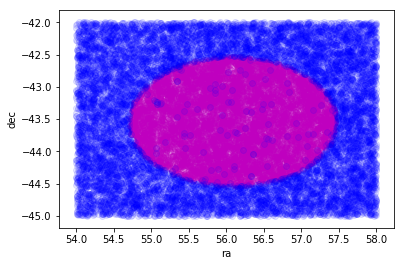

In [30]:
#ididx = dgaia_all['id'] != dg
plt.scatter(dgaia_retii['ra'].values, dgaia_retii['dec'].values, c='m',alpha=0.25)
plt.scatter(dgaia_rest['ra'].values, dgaia_rest['dec'].values, c='b',alpha=0.1)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

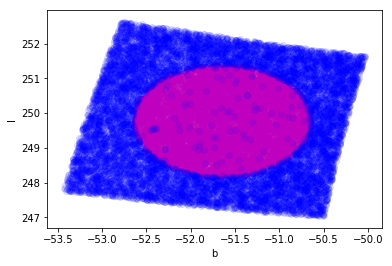

In [31]:
#ididx = dgaia_all['id'] != dg
plt.scatter(dgaia_retii['b'].values, dgaia_retii['l'].values, c='m',alpha=0.25)
plt.scatter(dgaia_rest['b'].values, dgaia_rest['l'].values, c='b',alpha=0.1)
plt.xlabel('b')
plt.ylabel('l')
plt.show()

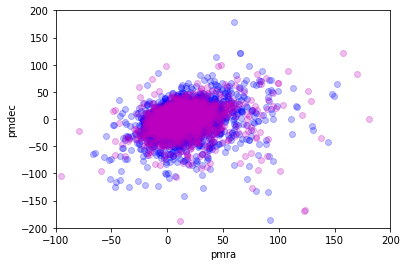

In [32]:
#ididx = dgaia_all['id'] != dg
plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',zorder=999,alpha=0.25)
plt.scatter(dgaia_rest['pmra'].values, dgaia_rest['pmdec'].values, c='b',alpha=0.25)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.xlim(-100,200)
plt.ylim(-200,200)
plt.show()

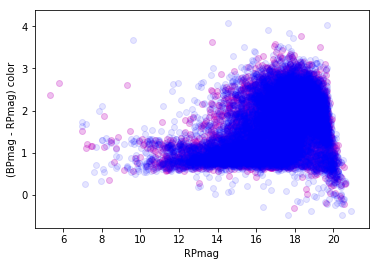

In [33]:
#ididx = dgaia_all['id'] != dg
#ididx = dgaia_all['id'] != dg

dgaia_retii['BRcolor'] = dgaia_retii['BPmag'].values - dgaia_retii['RPmag'].values
dgaia_rest['BRcolor'] = dgaia_rest['BPmag'].values - dgaia_rest['RPmag'].values

plt.scatter(dgaia_retii['RPmag'].values, dgaia_retii['BRcolor'].values, c='m',alpha=0.25)
plt.scatter(dgaia_rest['RPmag'].values, dgaia_rest['BRcolor'].values, c='b',alpha=0.1)
plt.xlabel('RPmag')
plt.ylabel('(BPmag - RPmag) color')
plt.show()

In [47]:
# Need to this from terminal?
! pip install --user --upgrade corner

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Requirement already up-to-date: corner in /home/jail/dlusers/drphilmarshall/.local/lib/python2.7/site-packages (2.0.1)


In [57]:
def make_corner_plot(members, rest):
    """
    Use the corner package to show density of member stars cf background in multiple dimensions.
    """
    cols = ['ra', 'dec', 'pmra', 'pmdec', 'BRcolor', 'RPmag']
    axis_labels = {}
    axis_labels['ra'] = 'RA / deg'
    axis_labels['dec'] = 'Dec / deg'
    axis_labels['pmra'] = 'RA proper motion / $\mu$as/yr'
    axis_labels['pmdec'] = 'Dec proper motion / $\mu$as/yr'
    axis_labels['BRcolor'] = '(B-R) color / mag'
    axis_labels['RPmag'] = 'R magnitude'
    p = len(names)
    labels = []
    
    features = np.array([])
    n = len(members)
    for col in cols:
        features = np.append(features, members[col].values)
        labels.append(axis_labels[col])
    members_features = features.reshape(p,n).transpose()
    
    features = np.array([])
    n = len(rest)
    for col in cols:
        features = np.append(features, rest[col].values)
    rest_features = features.reshape(p,n).transpose()
    
    figure = corner.corner(rest_features, labels=labels, color='blue', smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))
    corner.corner(member_features, labels=labels, color='magenta', smooth=1.3, fig=figure, hist_kwargs=dict(normed=True))

    return

In [50]:
import corner
make_corner_plot(dgaia_retii, dgaia_rest)

ModuleNotFoundError: No module named 'corner'

### Verify

Let's check that we really are looking at the right sky region...

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np

In [ ]:
c = SkyCoord(ra=dgaia['ra'].values * u.degree, dec=dgaia['dec'].values * u.degree, frame='icrs')

In [ ]:
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="mollweide")
plt.title("Eri II")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.subplots_adjust(top=0.95,bottom=0.0)
#plt.xlim(30,60)
#plt.ylim(-45,-60)
plt.show()

In [ ]:
import pickle

dgaia.to_pickle('dgaia_eri_ii.bin')

#pkl_file = open('dgaia_eri_ii.bin', 'rb')
#data1 = pickle.load(pkl_file)

## Clustering with Spectral K-means

In [54]:
from sklearn import cluster

In [55]:
spectral = cluster.SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="nearest_neighbors")

In [98]:
# Munge data:

def gaia2sklearn(df, cols, target=0):
    X = df[cols]
    # Need to filter out problem values:
    X.replace([np.inf, -np.inf], np.nan)
    X.dropna(how='any') 
    assert len(np.where(np.isnan(X))[0]) == 0, "%d NaN values not dropped" % len(np.where(np.isnan(X))[0])
    # Make the response variables / labels:
    N = len(X)
    y = pd.DataFrame(np.zeros(N) + target, columns = ['target'])    
    return X, y


cols = ['ra', 'dec', 'pmra', 'pmdec', 'BRcolor', 'RPmag']

X0, y0 = gaia2sklearn(dgaia_rest, cols, target=0)
X1, y1 = gaia2sklearn(dgaia_retii, cols, target=1)

X, y = pd.concat([X0,X1]), pd.concat([y0,y1])

# Might need to do this, according to 
#   https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
# X = StandardScaler().fit_transform(X)

AssertionError: 353 NaN values not dropped

In [ ]:
spectral.fit(X)

In [93]:
len(dgaia_retii)

6575

(array([], dtype=int64), array([], dtype=int64))

In [99]:
Z = dgaia_retii[cols]
len(Z.dropna(how='any'))

6552

In [100]:
ZZ = Z.dropna(how='any')
np.where(np.isnan(ZZ))

(array([], dtype=int64), array([], dtype=int64))

In [101]:
len(np.where(np.isnan(ZZ))[0])

0